In [ ]:
img_path = "../tests/data/imagenes_a_testear/Wargames.1024x600.bmp"
er = ExpRunner(filter_name = "Sharpen",
            input_image_path = img_path,
            implementation = "asm", 
            output_image_dir = "./exp_ouºtput_images/")

er.run()

In [ ]:
img_path="../tests/data/imagenes_a_testear/Wargames.512x300.bmp"

mer=MultipleAsmImplementationsExpRunner(filter_name = "Sharpen",
            input_image_path=img_path,
            implementation = "asm", 
            output_image_dir = "./exp_output_images/")



mer.setup_asm_implementation("fuck_cache")
mer.run()

In [ ]:
sizes = []
times = []
filter_name = "Cuadrados"

filter_implementations_dir_path = "../filters/Implementaciones{}/".format(filter_name) 
implementations = [file.split('.')[0].split('_')[1] for file in os.listdir(filter_implementations_dir_path)]

sizes_vs_times = {}
for imp in implementations:
    
    for img_path in image_paths:
        mer=MultipleAsmImplementationsExpRunner(filter_name = filter_name,
                input_image_path=img_path,
                implementation = "asm", 
                output_image_dir = "./exp_output_images/")

        mer.setup_asm_implementation(imp)

        exps = get_exps(mer, 30, z_score_threshold=2.5)
        
        sizes.append(qty_pixels(img_path))
        times.append(exps["# de ciclos insumidos totales"].mean())

        size_vs_time_pair = list(zip(sizes,times))
        size_vs_time_pair.sort(key=lambda tup: tup[0])
    sizes_vs_times[imp] = size_vs_time_pair
sizes_vs_times

# Lo de arriba es mentira ;)

In [1]:
5+5

10

In [2]:
from subprocess import Popen, PIPE

def flatten_list_of_strings(args):
    output = ''
    for s in args:
        output += s
        output += ' '
    return output

def str_to_num(s):
    if '.' in s:
        return float(s)
    else:
        return int(s)

class ExpRunner():

    def __init__(self, filter_name, input_image_path, implementation, output_image_dir, verbose=False):
        self.tp_exec = '../build/tp2'
        self.filter_name = filter_name
        self.exp_results = {'filter_name': filter_name, 'implementation': implementation}
        self.run_args = [self.tp_exec, 
                         filter_name, 
                         input_image_path, 
                         "-i", implementation, 
                         "-o", output_image_dir]
        self.verbose = verbose
        
    def exp_keys(self):
        '''
        ["Comienzo",
                "Fin",
                "# de ciclos insumidos totales",  
                "# de ciclos insumidos por llamada"]
        '''
        return ["# de ciclos insumidos totales"] # por ahora solo nos interesa esta

    def run_executable(self,run_args):
        p = Popen(run_args, stdout=PIPE, bufsize=1)
        with p.stdout:
            for line in iter(p.stdout.readline, b''):
                line = line.decode("utf-8")
                try:
                    key, val = line[:-1].split(':')
                    key = key.strip(" ")
                    if(key in self.exp_keys()):
                        self.exp_results[key] = str_to_num(val)
                except:
                    pass
        p.wait() # wait for the subprocess to exit

    def print_help(self):
        self.run_executable([self.tp_exec, "-h"])
        return
            
    def run(self):
        if self.verbose:
            print("Run command:")
            print(flatten_list_of_strings(self.run_args))
            print
        self.run_executable(self.run_args)
        return dict(self.exp_results) # esto es para copiar el resultado

In [3]:
from shutil import copyfile
from subprocess import check_call

class MultipleAsmImplementationsExpRunner(ExpRunner):
    
    def setup_asm_implementation(self, asm_implementation):
        filters_path = "../filters/" 
        exp_filters_path = filters_path + "Implementaciones" + self.filter_name + "/"
        dest_implementation = "asm"
        
        src_asm = exp_filters_path + self.filter_name + '_' + asm_implementation + ".asm"
        dst_asm = filters_path + self.filter_name + '_' + dest_implementation + ".asm"
        copyfile(src_asm, dst_asm)
        
    def make_executable(self):
        check_call(["make"], cwd="../")
        # TODO: estaria cheto que esto avise explicitamente cuando falla el make
    
    def run(self):
        self.make_executable()
        return super().run()
        

### Cargar varias exp en un dataframe

In [4]:
import pandas as pd
from scipy import stats
import numpy as np

def get_exps(exp_runner, sample_size, z_score_threshold=2.5):

    # correr exps
    exps = pd.DataFrame([exp_runner.run() for i in range(sample_size)])

    # descartar outliers
    # exps = exps[stats.zscore(np.abs(exps['# de ciclos insumidos totales'])) < z_score_threshold]
    
    return exps


## obtener tamaños y tiempos de exps

In [5]:
def qty_pixels(img_name):
    rows, cols = img_name.split('/')[-1].split('.')[1].split('x')
    return int(rows) * int(cols)

### imagenes de distintos tamaños

In [6]:
import os

# img_names = ["Wargames", "NoCountryForOldMen"]

img_dir="../tests/data/imagenes_a_testear/"
image_paths = []
for img_name in os.listdir(img_dir):
    if "Wargames" in img_name:
        img_path = img_dir+img_name
        image_paths.append(img_path)

### correr exps :D

In [8]:
image_paths

['../tests/data/imagenes_a_testear/Wargames.1024x600.bmp',
 '../tests/data/imagenes_a_testear/Wargames.256x150.bmp',
 '../tests/data/imagenes_a_testear/Wargames.512x300.bmp',
 '../tests/data/imagenes_a_testear/Wargames.128x75.bmp',
 '../tests/data/imagenes_a_testear/Wargames.32x18.bmp',
 '../tests/data/imagenes_a_testear/Wargames.64x37.bmp']

In [40]:
sizes = []
times = []
filter_name = "Sharpen"

filter_implementations_dir_path = "../filters/Implementaciones{}/".format(filter_name) 
implementations = [file.split('.')[0].split('_')[1] for file in os.listdir(filter_implementations_dir_path)]

# shorter exp time
#qty_exps=30
qty_exps=1000
img_qty=4

sizes_vs_times = {}
exp_dfs_per_imp = []
imp="baseline"
img_path=image_paths[1] # 256x150

mer=MultipleAsmImplementationsExpRunner(filter_name = filter_name,
        input_image_path=img_path,
        implementation = "asm", 
        output_image_dir = "./exp_output_images/",
        verbose=False)

mer.setup_asm_implementation(imp)

exps = get_exps(mer, qty_exps, z_score_threshold=2.5)
exps['implementation'] = imp

exps['qty_pixels'] = qty_pixels(img_path)

exp_dfs_per_imp.append(exps)

exp_df = pd.concat(exp_dfs_per_imp)

In [25]:
exp_df = pd.concat(exp_dfs_per_imp)

In [41]:
exp_df['millones de ciclos'] = exp_df['# de ciclos insumidos totales'] / 1000000

### Distribucion de tiempos de corrida para la misma exp mil veces

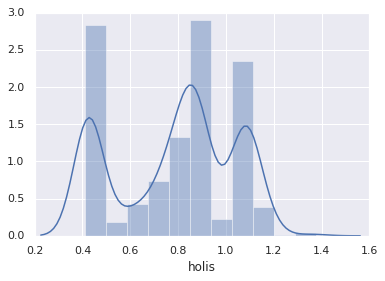

In [50]:
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline

import seaborn as sns
sns.set()

# Plot sepal with as a function of sepal_length across days
g = sns.distplot(exp_df["millones de ciclos"], axlabel='holis')

# Use more informative axis labels than are provided by default
# g.set_axis_labels("Sepal length (mm)", "Sepal width (mm)")

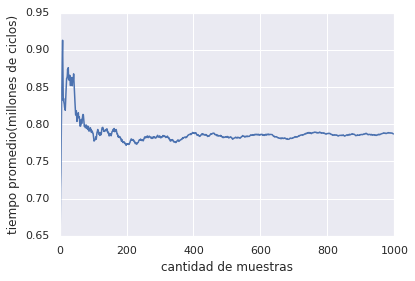

<Figure size 432x288 with 0 Axes>

In [90]:
qty_exps=len(exp_df.index)

mu_i = [np.mean(exp_df.head(i)["millones de ciclos"]) for i in range(qty_exps)]
mu_i = mu_i[1:] # la primera muestra da nan

ax = sns.lineplot(data=pd.Series(mu_i), );
ax.set(xlabel="cantidad de muestras", ylabel="tiempo promedio(millones de ciclos)")
plt.show()
plots_save_dir_path = './plots_decidir_cant_iteraciones/'
plot_name="promedio_muestral_vs_cantidad_de_muestras"
plt.savefig(plots_save_dir_path + plot_name + '.png')

In [87]:
ls

exp_output_images/        run_exp_base-decidir_cant_iteraciones.ipynb
multi_reg_iris.ipynb      run_exp_base-hacer_varias_imp.ipynb
run_exp.ipynb             run_exp_base.ipynb
run_exp_base-Copy1.ipynb


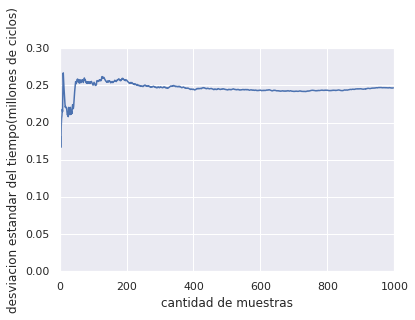

<Figure size 432x288 with 0 Axes>

In [89]:
sigma_i = [np.std(exp_df.head(i)["millones de ciclos"]) for i in range(qty_exps)]
sigma_i = sigma_i[1:] # la primera muestra da nan

ax = sns.lineplot(data=pd.Series(sigma_i), );
ax.set(xlabel="cantidad de muestras", ylabel="desviacion estandar del tiempo(millones de ciclos)")
plt.show()
plots_save_dir_path = './plots_decidir_cant_iteraciones/'
plot_name="desviacion_estandar_vs_cantidad_de_muestras"
plt.savefig(plots_save_dir_path + plot_name + '.png')

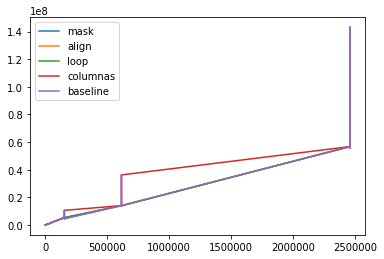

In [50]:
import matplotlib.pyplot as plt

for imp, exps in sizes_vs_times.items():
    sizes, times = zip(*exps)
    plt.plot(sizes, times, label=imp)

plt.legend()



In [ ]:
plt.plot(y=times, x=sizes)


## plotear resultados

In [2]:
import matplotlib.pyplot as plt
sizes, times = zip(*sizes_vs_times)
plt.plot(sizes, times)

NameError: name 'sizes_vs_times' is not defined

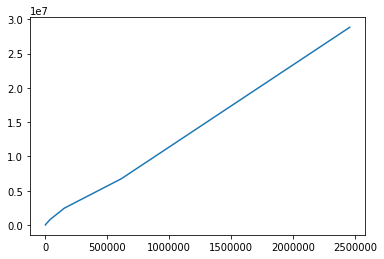

In [274]:
import matplotlib.pyplot as plt
sizes, times = zip(*sizes_vs_times)
plt.plot(sizes, times)